### Download the dataset

In [1]:
import os
import shutil
try:
    shutil.rmtree("/content/hi")
except:
    pass

try:
    os.remove("/content/hi.zip")
except:
    pass

try:
    shutil.rmtree("/content/wandb")
except:
    pass

In [2]:
%%capture
# !gdown https://drive.google.com/uc?id=1oG_Alz4wmqIMJxNPTZNuvYo1beMwTFHn
!gdown https://drive.google.com/uc?id=1TkaNm9ucnEn3S5Pz3D5SRFiroFgx4fjs
!unzip "/content/hi.zip"
!pip install wandb

In [3]:
!nvidia-smi

Sun May  2 15:46:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import libraries

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from wandb.keras import WandbCallback

### Load the data

In [5]:
# Load the training lexicons
with open("hi/lexicons/hi.translit.sampled.train.tsv") as f:
    training_lines = f.readlines()
training_pairs = [line.strip("\n").split("\t") for line in training_lines]
training_map = dict([(example[1], example[0]) for example in training_pairs])

# Load the validation lexicons
with open("hi/lexicons/hi.translit.sampled.dev.tsv") as f:
    validation_lines = f.readlines()
validation_pairs = [line.strip("\n").split("\t") for line in validation_lines]
validation_map = dict([(example[1], example[0]) for example in validation_pairs])

# Load the test lexicons
with open("hi/lexicons/hi.translit.sampled.test.tsv") as f:
    test_lines = f.readlines()
test_pairs = [line.strip("\n").split("\t") for line in test_lines]
test_map = dict([(example[1], example[0]) for example in test_pairs])

# Number of training examples
M_train = len(training_map.keys())

# Number of validation examples
M_val = len(validation_map.keys())

# Number of test examples
M_test = len(test_map.keys())

print(f"Number of training examples = {M_train}")
print(f"Number of validation examples = {M_val}")
print(f"Number of test examples = {M_test}")
print()

Number of training examples = 41345
Number of validation examples = 4321
Number of test examples = 4442



### Prepare the data

We have used "tab" for the START sequence character and "newline" as the END sequence character.

In [6]:
def extract_data_info(data_dict):
    """
    Returns important information about the data.
    """
    input_words = []
    target_words = []
    input_characters = []
    target_characters = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")
        # Add the characters to the respective character lists
        input_characters = list(set(input_characters + list(key)))
        target_characters = list(set(target_characters + list(data_dict[key])))

    # Sort the input characters
    input_characters = sorted(list(set(input_characters)))
    # Sort the target characters
    target_characters = target_characters + ["\t", "\n"]
    target_characters = sorted(list(set(target_characters)))

    # Number of unique tokens in the source language
    num_input_tokens = len(input_characters)
    # Number of unique tokens in the target language
    num_target_tokens = len(target_characters)

    # Max input word length
    max_encoder_seq_length = max([len(word) for word in input_words])
    # Max output word length
    max_decoder_seq_length = max([len(word) for word in target_words])

    print(f"Number of unique input characters: {num_input_tokens}")
    print(f"Number of unique output characters: {num_target_tokens}")
    print()
    print(f"Maximum sequence length for the input: {max_encoder_seq_length}")
    print(f"Maximum sequence length for the output: {max_decoder_seq_length}")

    # Map characters to numerical indices (using +1 to avoid any character being mapped to 0)
    input_char_map = dict([(ch, i + 1) for i, ch in enumerate(input_characters)])
    target_char_map = dict([(ch, i + 1) for i, ch in enumerate(target_characters)])

    return input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map

def make_one_hot_arrays(data_dict, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens):
    """
    This function takes the training/validation/test dictionary as input and produces
    the one-hot encoded versions of the respective data.
    """
    input_words = []
    target_words = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")

    M = len(data_dict.keys())
    encoder_input_array = np.zeros((M, max_encoder_seq_length, num_input_tokens + 1), dtype="float")
    decoder_input_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")
    decoder_output_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")

    for i in range(M):
        source_word = input_words[i]
        target_word = target_words[i]

        # One-hot encoding for the input
        for j, ch in enumerate(source_word):
            encoder_input_array[i, j, input_char_map[ch]] = 1.0

        # One-hot encoding for the output
        for j, ch in enumerate(target_word):
            decoder_input_array[i, j, target_char_map[ch]]= 1.0
            if j >= 1:
                # The decoder output is one step ahead of the decoder input
                decoder_output_array[i, j-1, target_char_map[ch]] = 1.0

    # encoder_input_array = []
    # decoder_input_array = []
    # decoder_output_array = []

    # for i in range(M):
    #     source_word = input_words[i]
    #     target_word = target_words[i]

    #     # Numerical encoding for the source word
    #     encoder_input_array.append([input_char_map[ch] for ch in source_word])

    #     # One-hot encoding for the output
    #     decoder_input_array.append([target_char_map[ch] for ch in target_word])
    #     # The decoder output is one step ahead of the decoder input
    #     decoder_output_array.append([target_char_map[ch] for ch in target_word][1:])

    return input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array

In [7]:
input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map = extract_data_info(training_map)

Number of unique input characters: 26
Number of unique output characters: 64

Maximum sequence length for the input: 20
Maximum sequence length for the output: 21


In [8]:
# Get the one-hot training matrices
input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array = make_one_hot_arrays(training_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_encoder_input_array = keras.preprocessing.sequence.pad_sequences(encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_decoder_input_array = keras.preprocessing.sequence.pad_sequences(decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_decoder_output_array = keras.preprocessing.sequence.pad_sequences(decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_decoder_output_array_oh = np.zeros((padded_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_decoder_output_array_oh[i][j][padded_decoder_output_array[i][j]] = 1.0

In [9]:
# Get the one-hot validation matrices
val_input_words, val_target_words, val_encoder_input_array, val_decoder_input_array, val_decoder_output_array = make_one_hot_arrays(validation_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_val_encoder_input_array = keras.preprocessing.sequence.pad_sequences(val_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_val_decoder_input_array = keras.preprocessing.sequence.pad_sequences(val_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_val_decoder_output_array = keras.preprocessing.sequence.pad_sequences(val_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_val_decoder_output_array_oh = np.zeros((padded_val_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_val_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_val_decoder_output_array_oh[i][j][padded_val_decoder_output_array[i][j]] = 1.0

In [10]:
# Get the one-hot validation matrices
test_input_words, test_target_words, test_encoder_input_array, test_decoder_input_array, test_decoder_output_array = make_one_hot_arrays(test_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_test_encoder_input_array = keras.preprocessing.sequence.pad_sequences(test_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_test_decoder_input_array = keras.preprocessing.sequence.pad_sequences(test_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_test_decoder_output_array = keras.preprocessing.sequence.pad_sequences(test_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_test_decoder_output_array_oh = np.zeros((padded_test_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_test_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_test_decoder_output_array_oh[i][j][padded_test_decoder_output_array[i][j]] = 1.0

In [11]:
# Using label encoding for the encoder inputs (and then find an embedding using the Embedding layer)
encoder_input_array = np.argmax(encoder_input_array, axis=2)
val_encoder_input_array = np.argmax(val_encoder_input_array, axis=2)
test_encoder_input_array = np.argmax(test_encoder_input_array, axis=2)

decoder_input_array = np.argmax(decoder_input_array, axis=2)
val_decoder_input_array = np.argmax(val_decoder_input_array, axis=2)
test_decoder_input_array = np.argmax(test_decoder_input_array, axis=2)

In [12]:
encoder_input_array[1]

array([ 1, 14, 11,  7,  1, 14,  9, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [13]:
decoder_input_array[1]

array([ 1,  6,  4, 18, 20, 31, 52, 32,  2,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

### Define the model

In [14]:
def define_model(num_cells, cell_type, num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, beam_size):
    """
    num_cells: Number of cells in the encoder and decoder layers
    cell_type: choice of cell type: Simple RNN, LSTM, GRU
    num_encoder_layers: Number of layers in the encoder
    num_decoder_layers: Number of layers in the decoder
    input_embedding_size: Dimenions of the vector to represent each character
    dropout_fraction: fraction of neurons to drop out
    """
    ## ENCODER
    # encoder_input = keras.Input(shape=(None, num_input_tokens), name="EncoderInput")
    encoder_input = keras.Input(shape=(None, ), name="EncoderInput")
    encoder_embedding = keras.layers.Embedding(num_input_tokens + 1, input_embedding_size, name="EncoderInputEmbedding", mask_zero=True)(encoder_input)

    # LSTM/RNN/GRU layer of the encoder
    for i in range(1, num_encoder_layers+1):
        if cell_type=="LSTM":
            if i==num_encoder_layers:
                encoder = keras.layers.LSTM(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction)
                # encoder_outputs, encoder_state_h, encoder_state_c = encoder(encoder_embedding)
            else:
                encoder = keras.layers.LSTM(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction)
                # encoder_outputs, encoder_state_h, encoder_state_c = encoder(encoder_embedding)

            if i==1:
                encoder_outputs, encoder_state_h, encoder_state_c = encoder(encoder_embedding)
            else:
                encoder_outputs, encoder_state_h, encoder_state_c = encoder(encoder_outputs)

        if cell_type=="RNN":
            if i==num_encoder_layers:
                encoder = keras.layers.SimpleRNN(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction)
            else:
                encoder = keras.layers.SimpleRNN(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction)
            if i==1:
                whole_sequence_output, rnn_final_state = encoder(encoder_embedding)
            else:
                whole_sequence_output, rnn_final_state = encoder(whole_sequence_output)

        if cell_type=="GRU":
            if i==num_encoder_layers:
                encoder = keras.layers.GRU(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction)
            else:
                encoder = keras.layers.GRU(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction)
            if i==1:
                whole_sequence_output, gru_final_state = encoder(encoder_embedding)
            else:
                whole_sequence_output, gru_final_state = encoder(whole_sequence_output)


    ## DECODER
    decoder_input = keras.Input(shape=(None, ), name="DecoderInput")
    decoder_embedding = keras.layers.Embedding(num_target_tokens + 1, 64, name="DecoderInputEmbedding", mask_zero=True)(decoder_input)


    for i in range(1, num_decoder_layers+1):
        if cell_type=="LSTM":
            decoder_lstm = keras.layers.LSTM(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction)
            if i==1:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embedding, initial_state = [encoder_state_h, encoder_state_c])
            else:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_outputs, initial_state = [decoder_state_h, decoder_state_c])
                

        if cell_type=="RNN":
            decoder_rnn = keras.layers.SimpleRNN(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction)
            if i==1:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_embedding, initial_state = rnn_final_state)
            else:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_outputs, initial_state = rnn_decoder_final_state)

        if cell_type=="GRU":
            decoder_gru = keras.layers.GRU(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction)
            if i==1:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_embedding, initial_state = gru_final_state)
            else:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_outputs, initial_state = gru_decoder_final_state)

    decoder_dense = keras.layers.Dense(num_target_tokens + 1, activation="softmax", name="DecoderDenseLayer") # Softmax picks one character
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = keras.Model([encoder_input, decoder_input], decoder_outputs)

    return model

### Training the model with hyperparameter search (WANDB)

In [15]:
def train_with_wandb():
    """
    This function performs hyperparameter search using WANDB
    """
    , , num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, 

    # Default values for hyper-parameters
    config_defaults = {
        "num_cells": 256,
        "cell_type": "LSTM",
        "num_encoder_layers": 1,
        "num_decoder_layers": 1,
        "input_embedding_size": 16,
        "dropout_fraction": 0,
        "beam_size": 1
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    cell_type = config.cell_type
    num_cells = config.num_cells
    num_encoder_layers = config.num_encoder_layers
    num_decoder_layers = config.num_decoder_layers
    input_embedding_size = config.input_embedding_size
    dropout_fraction = config.dropout_fraction
    beam_size = config.beam_size
    
    # Display the hyperparameters
    run_name = "cell_{}_ncell_{}_elayer_{}_dlayer_{}_emb_{}_dp_{}_bm_{}".format(cell_type, num_cells, num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, beam_size)
    print(run_name)

    # Define the model
    model = define_model(num_cells, cell_type, num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, beam_size)
    print(model.summary())

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit(
            [encoder_input_array, decoder_input_array],
            decoder_output_array,
            batch_size = 64,
            epochs = 20,
            verbose = 2,
            validation_data = ([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array),
            callbacks=[WandbCallback()]
            )

    # Plots of accuracy and loss
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.plot(history.history["accuracy"], label = "Training accuracy")
    plt.title("Accuracy vs epoch", size=14)
    plt.legend()
    plt.show()

    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.plot(history.history["loss"], label = "Training loss")
    plt.title("Loss vs epoch", size=14)
    plt.legend()
    plt.show()

    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: s6b4ja84
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_3/sweeps/s6b4ja84
Sweep ID = s6b4ja84


wandb: Agent Starting Run: cnyr39fu with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


cell_LSTM_ncell_256_elayer_3_dlayer_3_emb_16_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 256),  279552      EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
_______________________________________

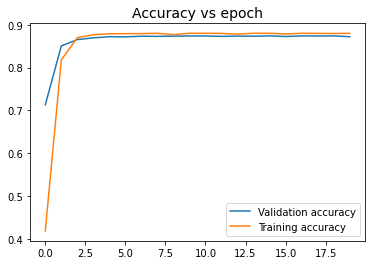

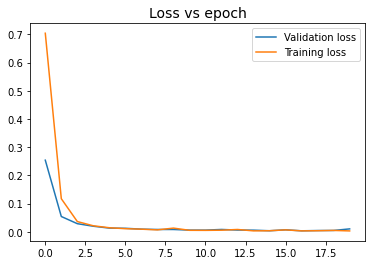

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00329
accuracy,0.87991
val_loss,0.01048
val_accuracy,0.87201
_runtime,487
_timestamp,1619938113
_step,19
best_val_loss,0.00368
best_epoch,16


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▇██████████████████
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇██████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 7dwueasy with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3


cell_RNN_ncell_512_elayer_3_dlayer_3_emb_64_dp_0_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 512),  295424      EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
________________________________________

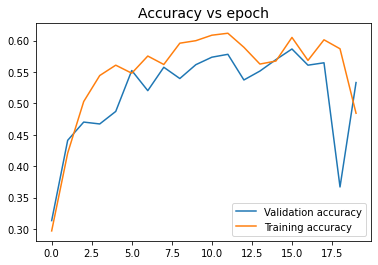

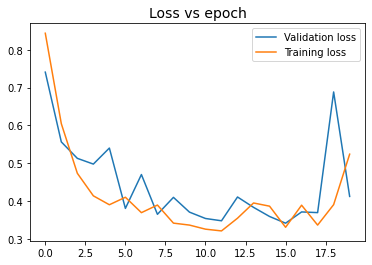

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.52391
accuracy,0.48425
val_loss,0.41225
val_accuracy,0.53309
_runtime,2185
_timestamp,1619940307
_step,19
best_val_loss,0.34147
best_epoch,15


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▃▂▂▂▂▂▁▁▁▁▁▂▂▁▂▁▂▄
accuracy,▁▄▆▇▇▇▇▇█████▇▇█▇█▇▅
val_loss,█▅▄▄▄▂▃▁▂▂▁▁▂▂▁▁▂▁▇▂
val_accuracy,▁▄▅▅▅▇▆▇▇▇██▇▇██▇▇▂▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 7dv458aw with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1


cell_GRU_ncell_256_elayer_1_dlayer_1_emb_32_dp_0_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
________________________________________

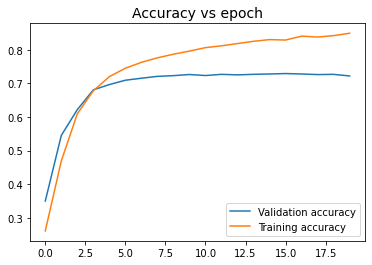

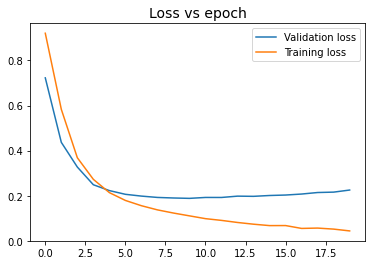

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.04366
accuracy,0.84938
val_loss,0.225
val_accuracy,0.72225
_runtime,202
_timestamp,1619940516
_step,19
best_val_loss,0.18808
best_epoch,9


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▆▇▇▇▇▇▇█████████
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇███████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 368pobzm with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1


cell_LSTM_ncell_512_elayer_1_dlayer_1_emb_64_dp_0.1_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
_____________________________________

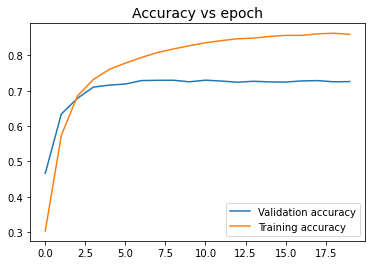

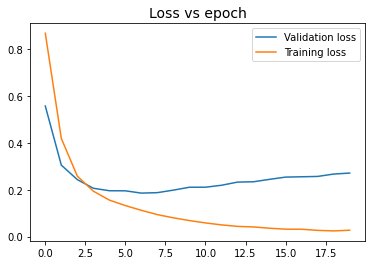

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.02731
accuracy,0.85942
val_loss,0.27106
val_accuracy,0.72562
_runtime,216
_timestamp,1619940739
_step,19
best_val_loss,0.1856
best_epoch,6


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▆▇▇▇▇▇███████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃
val_accuracy,▁▅▇▇████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: i7mfpqzi with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 3


cell_GRU_ncell_512_elayer_3_dlayer_2_emb_32_dp_0_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (GRU)             [(None, None, 512),  838656      EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
________________________________________

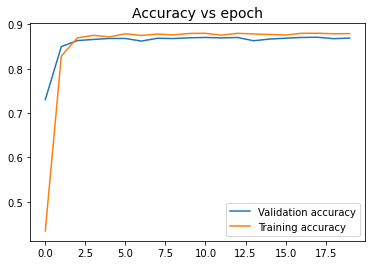

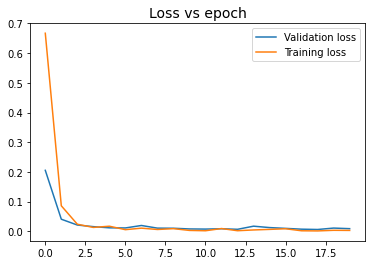

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00295
accuracy,0.87917
val_loss,0.00884
val_accuracy,0.86902
_runtime,428
_timestamp,1619941175
_step,19
best_val_loss,0.00609
best_epoch,17


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▇██████████████████
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇██████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: o6mtbawg with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2


cell_GRU_ncell_512_elayer_2_dlayer_1_emb_64_dp_0.1_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (GRU)             [(None, None, 512),  887808      EncoderInputEmbedding[0][0]      
______________________________________

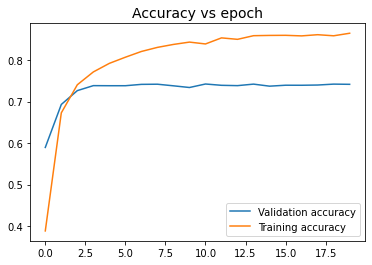

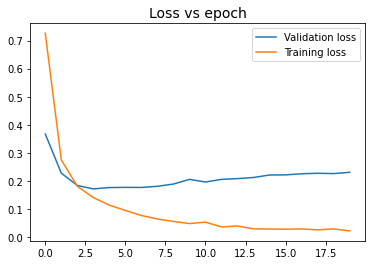

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.02113
accuracy,0.86444
val_loss,0.2302
val_accuracy,0.74146
_runtime,290
_timestamp,1619941474
_step,19
best_val_loss,0.17106
best_epoch,3


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▇▇▇▇▇████████████
val_loss,█▃▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃
val_accuracy,▁▆▇█████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: x5mf5224 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1


cell_LSTM_ncell_512_elayer_1_dlayer_1_emb_16_dp_0.1_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
_____________________________________

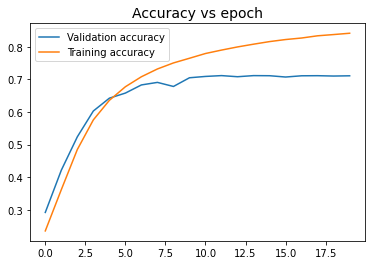

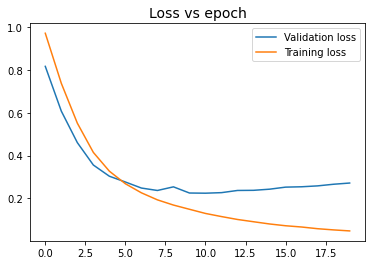

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.04881
accuracy,0.84196
val_loss,0.27209
val_accuracy,0.71126
_runtime,215
_timestamp,1619941697
_step,19
best_val_loss,0.22472
best_epoch,10


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▄▅▆▆▆▇▇▇▇▇████████
val_loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_accuracy,▁▃▅▆▇▇██▇███████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: xyhqvrx1 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2


cell_LSTM_ncell_512_elayer_2_dlayer_2_emb_64_dp_0_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 512),  1181696     EncoderInputEmbedding[0][0]      
_______________________________________

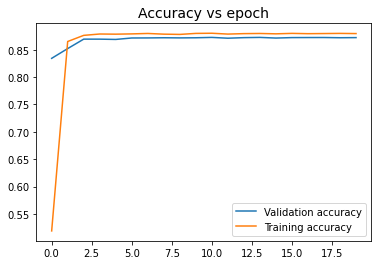

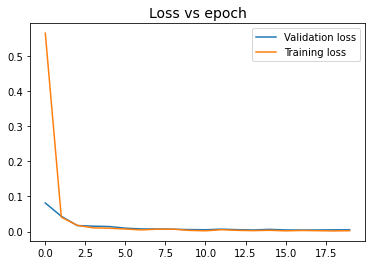

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00235
accuracy,0.87941
val_loss,0.00489
val_accuracy,0.87204
_runtime,399
_timestamp,1619942108
_step,19
best_val_loss,0.00423
best_epoch,16


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁███████████████████
val_loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▇▇▇███████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 0ahaaay2 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3


cell_LSTM_ncell_128_elayer_3_dlayer_3_emb_16_dp_0_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 128),  74240       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
_______________________________________

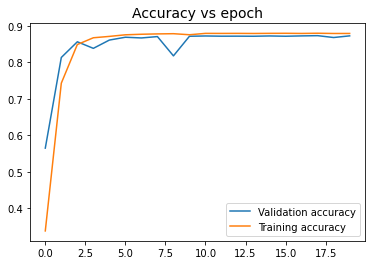

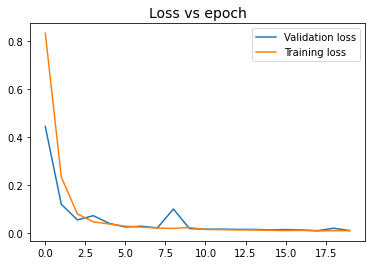

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00948
accuracy,0.87934
val_loss,0.00998
val_accuracy,0.87274
_runtime,458
_timestamp,1619942576
_step,19
best_val_loss,0.00933
best_epoch,17


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆██████████████████
val_loss,█▃▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇█▇████▇███████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: mta1g4ag with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2


cell_LSTM_ncell_128_elayer_2_dlayer_2_emb_32_dp_0.1_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 128),  82432       EncoderInputEmbedding[0][0]      
_____________________________________

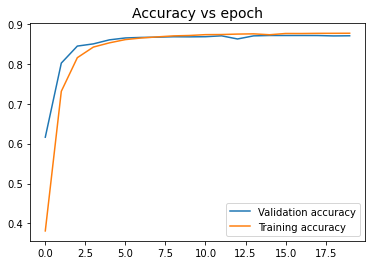

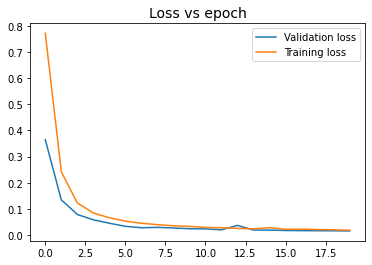

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.01812
accuracy,0.87705
val_loss,0.0154
val_accuracy,0.8707
_runtime,323
_timestamp,1619942907
_step,19
best_val_loss,0.0154
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆▇█████████████████
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇████████████████
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: mw3ppso5 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 1


cell_LSTM_ncell_512_elayer_1_dlayer_2_emb_32_dp_0.1_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
_____________________________________

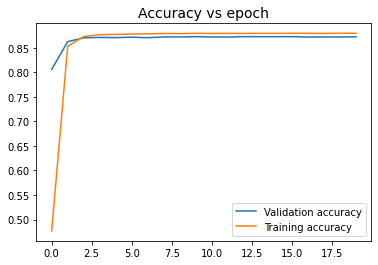

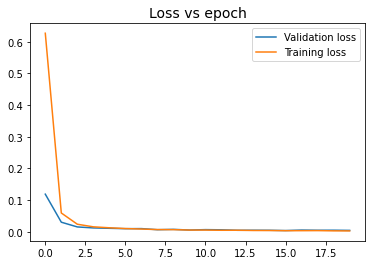

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00287
accuracy,0.87961
val_loss,0.00452
val_accuracy,0.87239
_runtime,296
_timestamp,1619943212
_step,19
best_val_loss,0.00405
best_epoch,15


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁███████████████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇██████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: wji1b4fj with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3


cell_RNN_ncell_256_elayer_3_dlayer_1_emb_32_dp_0_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 256),  73984       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
________________________________________

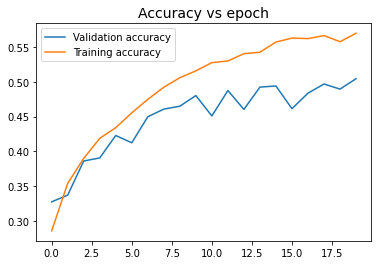

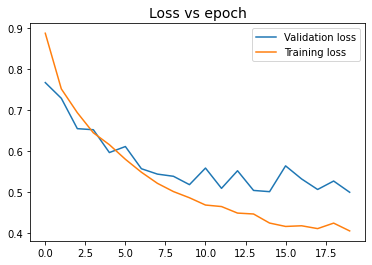

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.40472
accuracy,0.56982
val_loss,0.49905
val_accuracy,0.50443
_runtime,1327
_timestamp,1619944548
_step,19
best_val_loss,0.49905
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
val_loss,█▇▅▅▄▄▃▂▂▁▃▁▂▁▁▃▂▁▂▁
val_accuracy,▁▁▃▃▅▄▆▆▆▇▆▇▆██▆▇█▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: bhd985fn with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2


cell_RNN_ncell_256_elayer_2_dlayer_2_emb_16_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 256),  69888       EncoderInputEmbedding[0][0]      
________________________________________

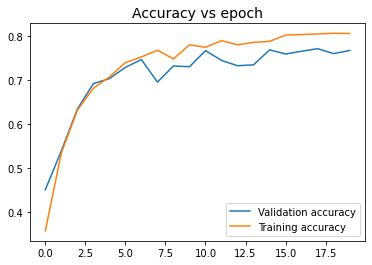

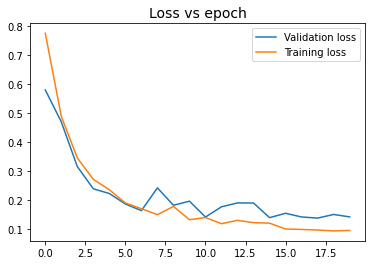

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.09582
accuracy,0.80575
val_loss,0.14247
val_accuracy,0.76713
_runtime,1327
_timestamp,1619945884
_step,19
best_val_loss,0.13839
best_epoch,17


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇▇▇███████████
val_loss,█▆▄▃▂▂▁▃▂▂▁▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇▆▇▇█▇▇▇██████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 9884qwum with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 1


cell_LSTM_ncell_512_elayer_1_dlayer_2_emb_32_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
_______________________________________

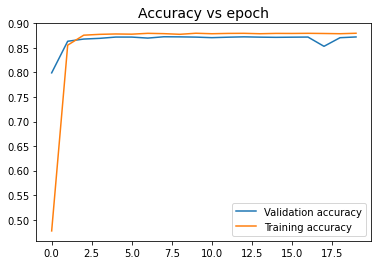

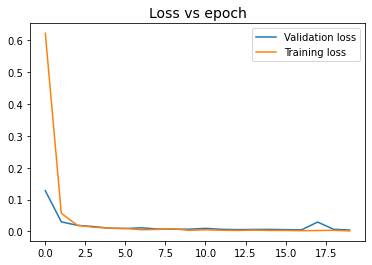

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00178
accuracy,0.87989
val_loss,0.00446
val_accuracy,0.87236
_runtime,296
_timestamp,1619946189
_step,19
best_val_loss,0.00446
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁███████████████████
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_accuracy,▁▇███████████████▆██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: qgf8klqm with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 2


cell_LSTM_ncell_256_elayer_2_dlayer_3_emb_16_dp_0.1_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 256),  279552      EncoderInputEmbedding[0][0]      
_____________________________________

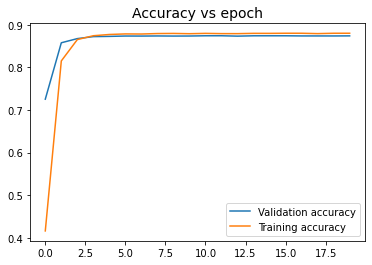

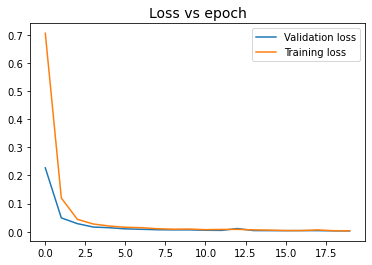

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00336
accuracy,0.87995
val_loss,0.00284
val_accuracy,0.87381
_runtime,405
_timestamp,1619946603
_step,19
best_val_loss,0.00284
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▇██████████████████
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇██████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: t4pa4vhz with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 1


cell_LSTM_ncell_256_elayer_1_dlayer_3_emb_64_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
_______________________________________

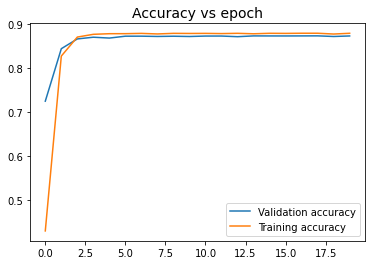

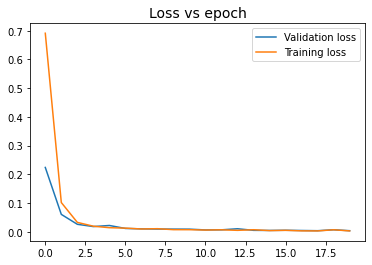

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00299
accuracy,0.87996
val_loss,0.00369
val_accuracy,0.87387
_runtime,337
_timestamp,1619946948
_step,19
best_val_loss,0.00369
best_epoch,17


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▇██████████████████
val_loss,█▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇██████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: juhiis7h with config:
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3


cell_GRU_ncell_256_elayer_3_dlayer_3_emb_64_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (GRU)             [(None, None, 256),  247296      EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
________________________________________

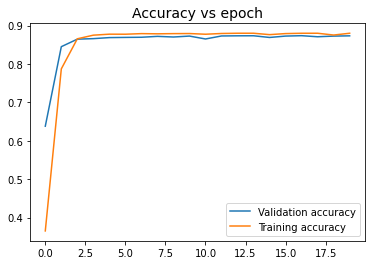

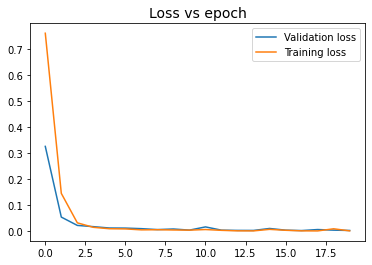

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00084
accuracy,0.88007
val_loss,0.00239
val_accuracy,0.87335
_runtime,447
_timestamp,1619947416
_step,19
best_val_loss,0.00206
best_epoch,16


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▇██████████████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇██████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: g39y8bwz with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3


cell_RNN_ncell_256_elayer_3_dlayer_3_emb_64_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 256),  82176       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
________________________________________

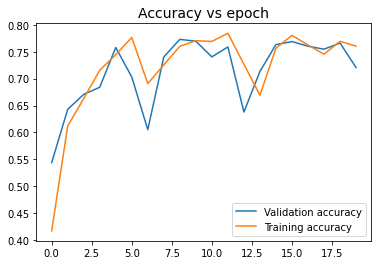

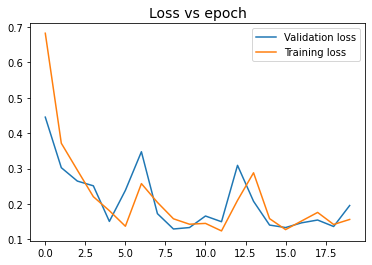

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.15648
accuracy,0.76057
val_loss,0.19581
val_accuracy,0.72073
_runtime,2047
_timestamp,1619949471
_step,19
best_val_loss,0.12959
best_epoch,8


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▁▃▂▁▁▁▁▂▃▁▁▁▂▁▁
accuracy,▁▅▆▇▇█▆▇████▇▆▇██▇██
val_loss,█▅▄▄▁▃▆▂▁▁▂▁▅▃▁▁▁▂▁▂
val_accuracy,▁▄▅▅█▆▃▇██▇█▄▆███▇█▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: nvfdqn9g with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 3


cell_RNN_ncell_128_elayer_3_dlayer_2_emb_32_dp_0.1_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 128),  20608       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
______________________________________

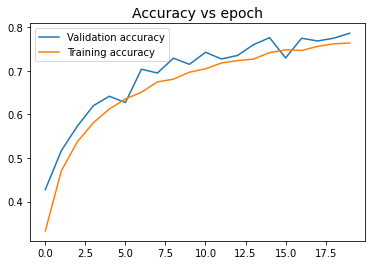

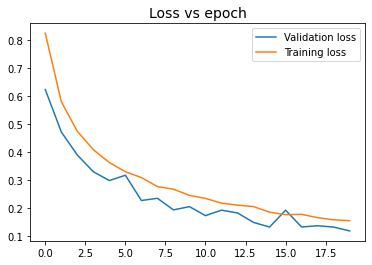

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.15603
accuracy,0.76357
val_loss,0.1197
val_accuracy,0.78602
_runtime,1936
_timestamp,1619951417
_step,19
best_val_loss,0.1197
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▆▅▄▃▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁
val_accuracy,▁▃▄▅▅▅▆▆▇▇▇▇▇▇█▇████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 16qebt5r with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 2


cell_RNN_ncell_256_elayer_2_dlayer_1_emb_32_dp_0_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 256),  73984       EncoderInputEmbedding[0][0]      
________________________________________

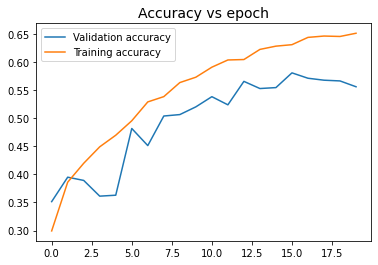

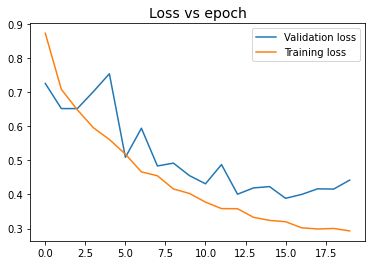

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.29309
accuracy,0.65203
val_loss,0.44182
val_accuracy,0.55652
_runtime,1014
_timestamp,1619952440
_step,19
best_val_loss,0.38859
best_epoch,15


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▃▃▄▄▅▆▆▆▆▇▇▇▇██████
val_loss,▇▆▆▇█▃▅▃▃▂▂▃▁▂▂▁▁▂▂▂
val_accuracy,▁▂▂▁▁▅▄▆▆▆▇▆█▇▇████▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 8qequ3r3 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 1


cell_LSTM_ncell_128_elayer_1_dlayer_3_emb_64_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
_______________________________________

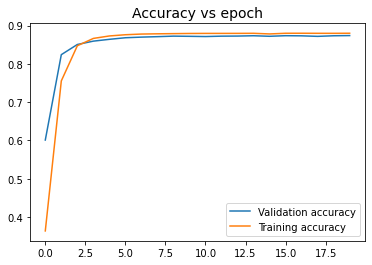

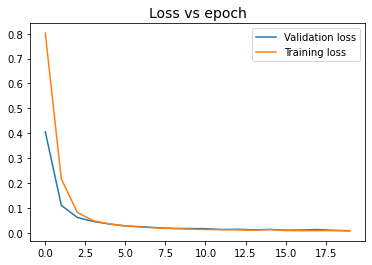

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00751
accuracy,0.87999
val_loss,0.00841
val_accuracy,0.8739
_runtime,332
_timestamp,1619952781
_step,19
best_val_loss,0.00841
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆██████████████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇█████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 0u9qqqt2 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 3


cell_LSTM_ncell_512_elayer_3_dlayer_2_emb_16_dp_0_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 512),  1083392     EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
_______________________________________

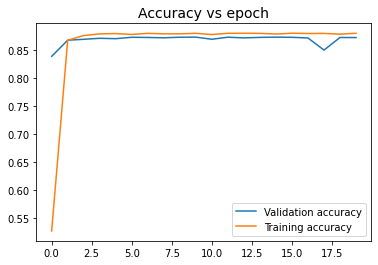

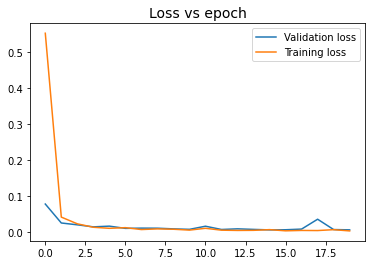

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00253
accuracy,0.87997
val_loss,0.00551
val_accuracy,0.8723
_runtime,465
_timestamp,1619953254
_step,19
best_val_loss,0.00538
best_epoch,14


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁███████████████████
val_loss,█▃▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▄▁▁
val_accuracy,▁▇▇█▇█████▇██████▃██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: tlmz5gei with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 2


cell_LSTM_ncell_512_elayer_2_dlayer_3_emb_64_dp_0_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 512),  1181696     EncoderInputEmbedding[0][0]      
_______________________________________

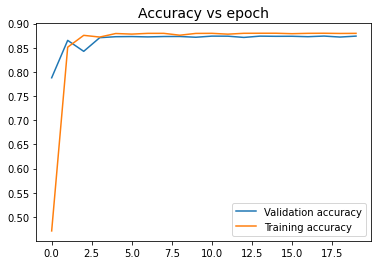

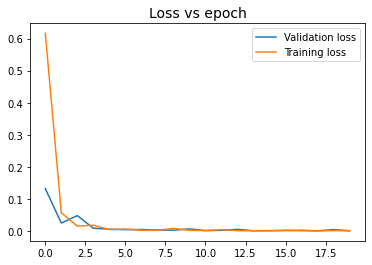

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00145
accuracy,0.87972
val_loss,0.00121
val_accuracy,0.87399
_runtime,477
_timestamp,1619953745
_step,19
best_val_loss,0.0012
best_epoch,17


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁███████████████████
val_loss,█▂▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▅█████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: j3pfrni0 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 2


cell_LSTM_ncell_128_elayer_2_dlayer_3_emb_64_dp_0.1_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 128),  98816       EncoderInputEmbedding[0][0]      
_____________________________________

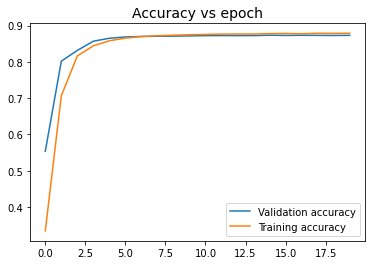

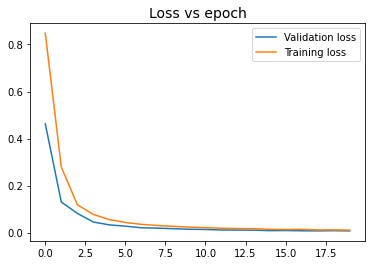

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.01038
accuracy,0.87873
val_loss,0.0071
val_accuracy,0.87294
_runtime,402
_timestamp,1619954161
_step,19
best_val_loss,0.0071
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆▇█████████████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇█████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: hj2ufb0g with config:
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 2


cell_GRU_ncell_512_elayer_2_dlayer_3_emb_64_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (GRU)             [(None, None, 512),  887808      EncoderInputEmbedding[0][0]      
________________________________________

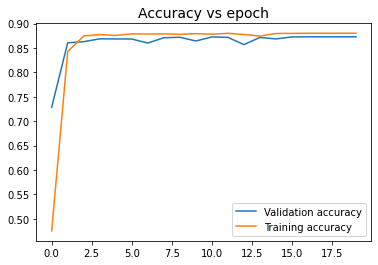

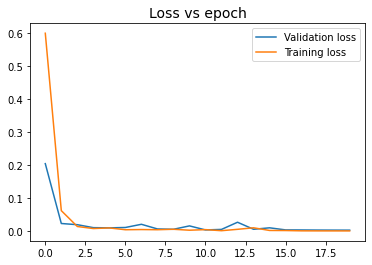

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00016
accuracy,0.88009
val_loss,0.00246
val_accuracy,0.87282
_runtime,417
_timestamp,1619954587
_step,19
best_val_loss,0.00246
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▇██████████████████
val_loss,█▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
val_accuracy,▁▇████▇█████▇███████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: ws0ja3yp with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2


cell_LSTM_ncell_128_elayer_2_dlayer_2_emb_32_dp_0.1_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 128),  82432       EncoderInputEmbedding[0][0]      
_____________________________________

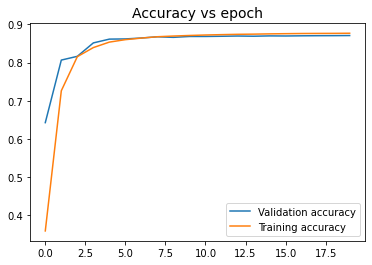

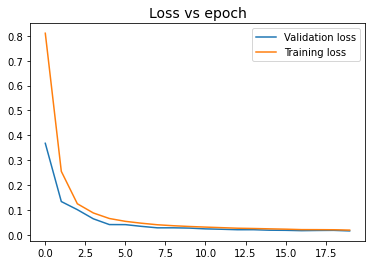

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.01848
accuracy,0.87696
val_loss,0.01519
val_accuracy,0.87093
_runtime,326
_timestamp,1619954925
_step,19
best_val_loss,0.01519
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆▇▇████████████████
val_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▇████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 79dowlj3 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 1


cell_RNN_ncell_512_elayer_1_dlayer_3_emb_32_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
________________________________________

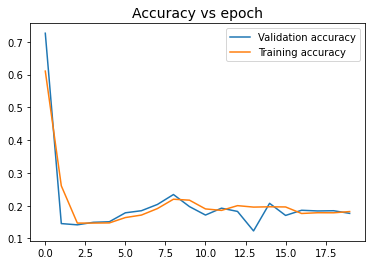

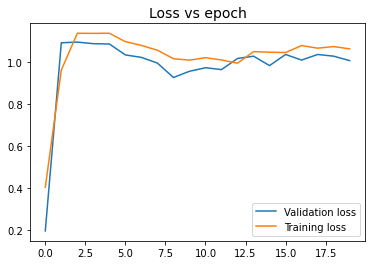

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,1.06303
accuracy,0.18201
val_loss,1.00715
val_accuracy,0.17651
_runtime,1387
_timestamp,1619956322
_step,19
best_val_loss,0.19666
best_epoch,0


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▁▆████▇▇▇▇▇▇▇▇▇▇▇▇▇▇
accuracy,█▃▁▁▁▁▁▂▂▂▂▂▂▂▂▂▁▁▁▂
val_loss,▁█████▇▇▇▇▇▇▇▇▇█▇█▇▇
val_accuracy,█▁▁▁▁▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: yb94jzmz with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3


cell_LSTM_ncell_256_elayer_3_dlayer_1_emb_16_dp_0.1_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 256),  279552      EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
_____________________________________

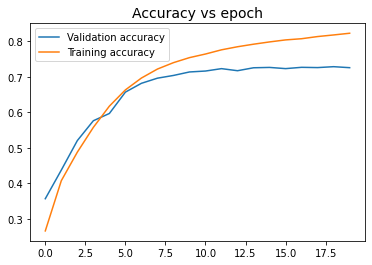

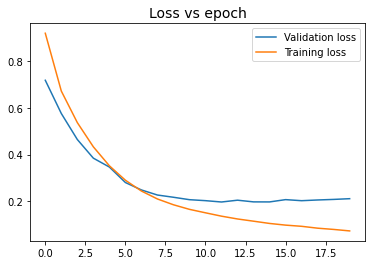

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.07343
accuracy,0.82296
val_loss,0.21141
val_accuracy,0.72594
_runtime,325
_timestamp,1619956656
_step,19
best_val_loss,0.19722
best_epoch,11


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▇▇▇▇▇████████
val_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▇▇▇████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: yr3bfjbx with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3


cell_LSTM_ncell_128_elayer_3_dlayer_3_emb_64_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 128),  98816       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
_______________________________________

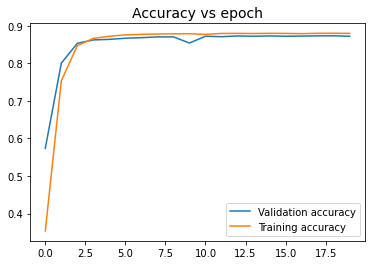

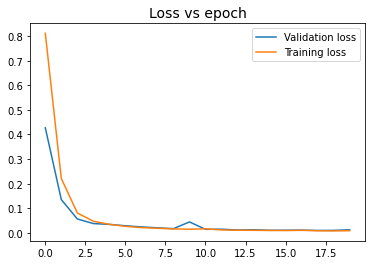

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00873
accuracy,0.87958
val_loss,0.01242
val_accuracy,0.87189
_runtime,460
_timestamp,1619957125
_step,19
best_val_loss,0.00982
best_epoch,17


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆██████████████████
val_loss,█▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆██████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xx31ge04 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 2


cell_LSTM_ncell_512_elayer_2_dlayer_2_emb_16_dp_0.1_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 512),  1083392     EncoderInputEmbedding[0][0]      
_____________________________________

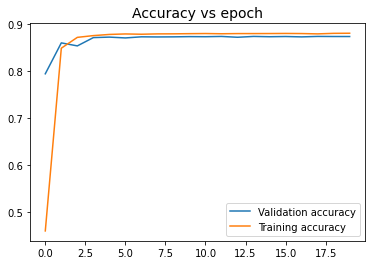

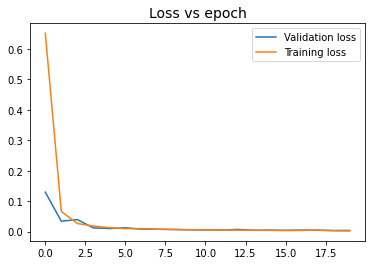

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00222
accuracy,0.87995
val_loss,0.00375
val_accuracy,0.87297
_runtime,388
_timestamp,1619957541
_step,19
best_val_loss,0.00362
best_epoch,18


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▇██████████████████
val_loss,█▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▆█████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 2mwoss3t with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3


cell_RNN_ncell_128_elayer_3_dlayer_3_emb_32_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 128),  20608       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
________________________________________

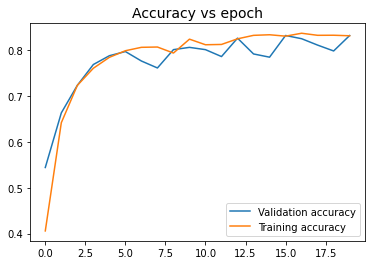

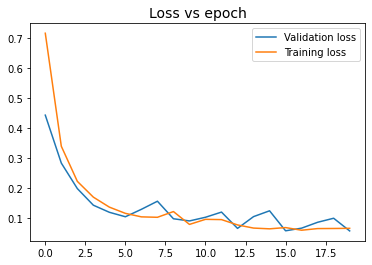

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.06612
accuracy,0.83094
val_loss,0.05748
val_accuracy,0.83152
_runtime,1893
_timestamp,1619959444
_step,19
best_val_loss,0.05748
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▇▇▇██▇███████████
val_loss,█▅▄▃▂▂▂▃▂▂▂▂▁▂▂▁▁▂▂▁
val_accuracy,▁▄▅▆▇▇▇▆▇▇▇▇█▇▇██▇▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: dgfdt3zw with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 3


cell_RNN_ncell_256_elayer_3_dlayer_3_emb_16_dp_0.1_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 256),  69888       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
______________________________________

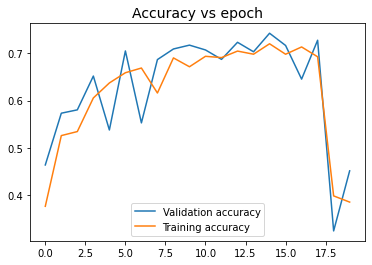

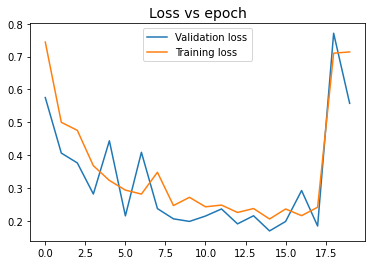

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.71441
accuracy,0.38564
val_loss,0.55771
val_accuracy,0.45161
_runtime,2493
_timestamp,1619961946
_step,19
best_val_loss,0.16888
best_epoch,14


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▃▃▂▂▃▂▂▁▂▁▁▁▁▁▁██
accuracy,▁▄▄▆▆▇▇▆▇▇▇▇█████▇▁▁
val_loss,▆▄▃▂▄▂▄▂▁▁▂▂▁▂▁▁▂▁█▆
val_accuracy,▃▅▅▆▅▇▅▇▇█▇▇█▇██▆█▁▃
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 80ez000i with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 1


cell_LSTM_ncell_128_elayer_1_dlayer_3_emb_32_dp_0_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
_______________________________________

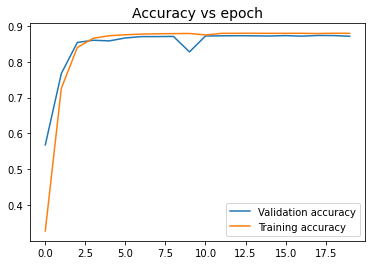

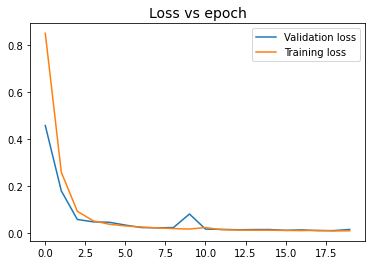

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00793
accuracy,0.87958
val_loss,0.0137
val_accuracy,0.87149
_runtime,319
_timestamp,1619962275
_step,19
best_val_loss,0.00871
best_epoch,17


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆▇█████████████████
val_loss,█▄▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆███████▇██████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: bnchuzr9 with config:
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 2


cell_LSTM_ncell_512_elayer_2_dlayer_3_emb_16_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 512),  1083392     EncoderInputEmbedding[0][0]      
_______________________________________

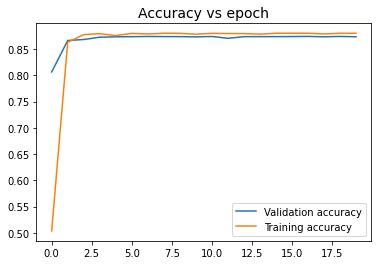

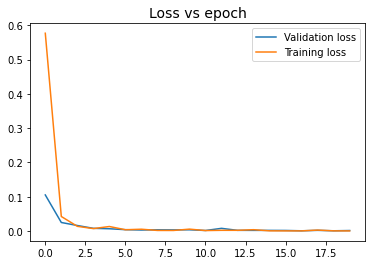

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.0006
accuracy,0.87999
val_loss,0.00175
val_accuracy,0.87332
_runtime,467
_timestamp,1619962750
_step,19
best_val_loss,0.00096
best_epoch,16


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁███████████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇█████████████████
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 5gqizrne with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 3


cell_LSTM_ncell_512_elayer_3_dlayer_2_emb_32_dp_0_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 512),  1116160     EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
_______________________________________

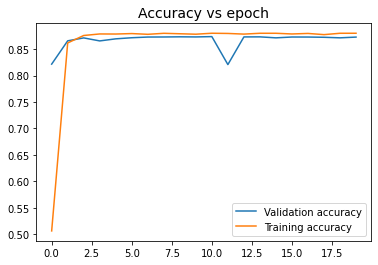

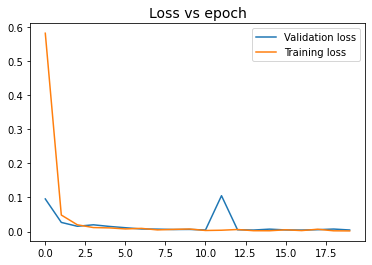

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00204
accuracy,0.87998
val_loss,0.00475
val_accuracy,0.87271
_runtime,468
_timestamp,1619963229
_step,19
best_val_loss,0.00458
best_epoch,16


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁███████████████████
val_loss,▇▃▂▂▂▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_accuracy,▁▇█▇▇██████▁████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 6xgai50x with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3


cell_RNN_ncell_256_elayer_3_dlayer_1_emb_32_dp_0_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 256),  73984       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
________________________________________

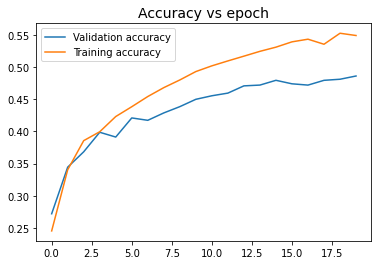

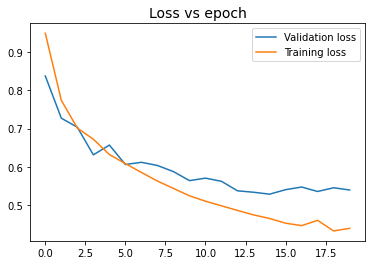

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.43891
accuracy,0.5489
val_loss,0.53931
val_accuracy,0.48603
_runtime,1355
_timestamp,1619964594
_step,19
best_val_loss,0.52833
best_epoch,14


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇▇██████
val_loss,█▅▅▃▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇███████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8atx5dsy with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 3


cell_RNN_ncell_256_elayer_3_dlayer_2_emb_32_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (SimpleRNN)       [(None, None, 256),  73984       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
________________________________________

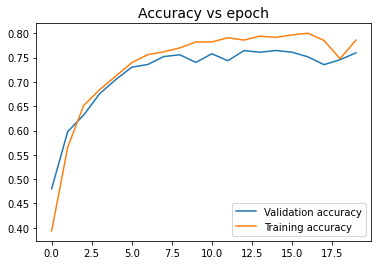

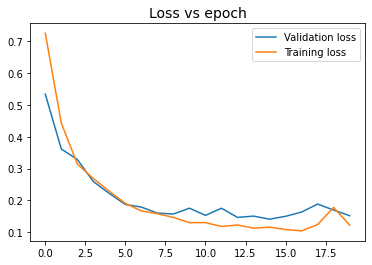

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.12223
accuracy,0.78607
val_loss,0.15182
val_accuracy,0.75992
_runtime,1711
_timestamp,1619966324
_step,19
best_val_loss,0.1409
best_epoch,14


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁
accuracy,▁▄▅▆▆▇▇▇▇█████████▇█
val_loss,█▅▄▃▂▂▂▁▁▂▁▂▁▁▁▁▁▂▂▁
val_accuracy,▁▄▅▆▇▇▇██▇█▇█████▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: ot72imc3 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 3


cell_LSTM_ncell_128_elayer_3_dlayer_2_emb_16_dp_0.1_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 128),  74240       EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
_____________________________________

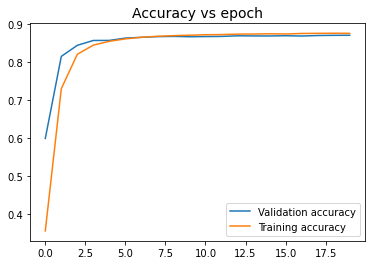

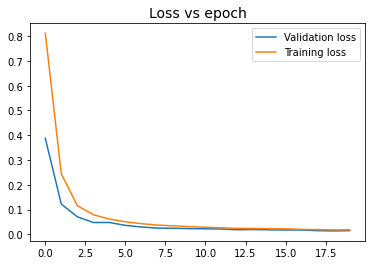

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.01849
accuracy,0.8765
val_loss,0.01518
val_accuracy,0.87143
_runtime,412
_timestamp,1619966747
_step,19
best_val_loss,0.01412
best_epoch,18


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆▇█████████████████
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇█████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: tz91ozwu with config:
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0.1
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 1


cell_GRU_ncell_256_elayer_1_dlayer_2_emb_16_dp_0.1_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
______________________________________

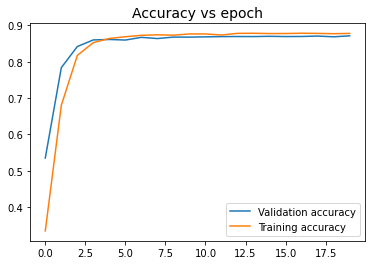

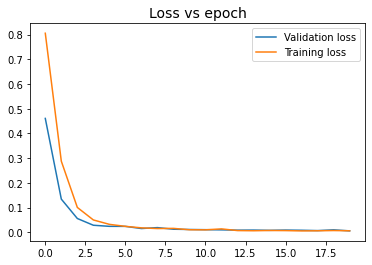

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00615
accuracy,0.87803
val_loss,0.00585
val_accuracy,0.8714
_runtime,284
_timestamp,1619967039
_step,19
best_val_loss,0.00585
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▇█████████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇█████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 6zsu9sqh with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 2


cell_GRU_ncell_512_elayer_2_dlayer_3_emb_32_dp_0_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (GRU)             [(None, None, 512),  838656      EncoderInputEmbedding[0][0]      
________________________________________

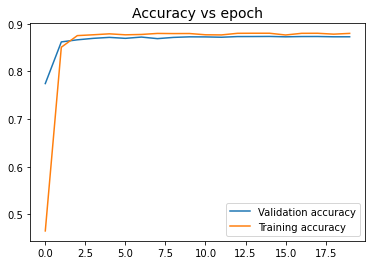

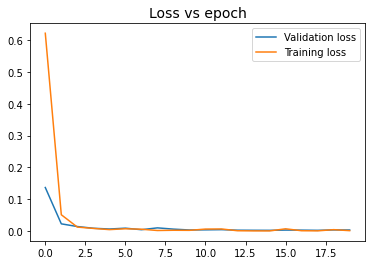

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00121
accuracy,0.87975
val_loss,0.00329
val_accuracy,0.87265
_runtime,449
_timestamp,1619967497
_step,19
best_val_loss,0.00222
best_epoch,14


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁███████████████████
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▇█████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 5llawdmo with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 512
wandb: 	num_decoder_layers: 3
wandb: 	num_encoder_layers: 1


cell_LSTM_ncell_512_elayer_1_dlayer_3_emb_32_dp_0_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
_______________________________________

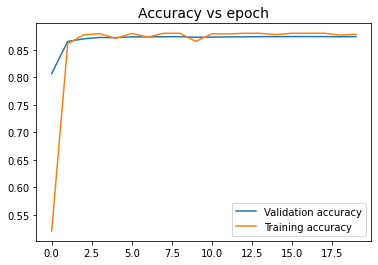

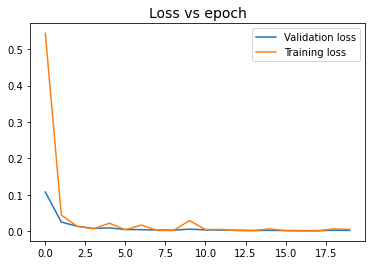

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.00471
accuracy,0.8781
val_loss,0.00187
val_accuracy,0.87384
_runtime,397
_timestamp,1619967904
_step,19
best_val_loss,0.00129
best_epoch,17


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁███████████████████
val_loss,█▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇██████████████████
_runtime,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: fxpjoobi with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 128
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 1


cell_LSTM_ncell_128_elayer_1_dlayer_2_emb_16_dp_0_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
_______________________________________

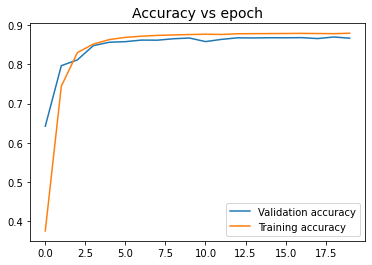

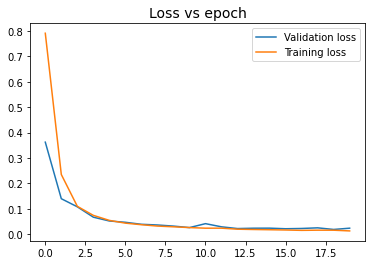

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.01272
accuracy,0.87943
val_loss,0.02347
val_accuracy,0.86686
_runtime,268
_timestamp,1619968180
_step,19
best_val_loss,0.01851
best_epoch,18


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▆▇█████████████████
val_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▇████████████████
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 6mr1aare with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1


cell_RNN_ncell_256_elayer_1_dlayer_1_emb_64_dp_0_bm_3
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
________________________________________

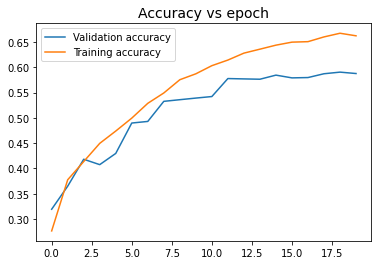

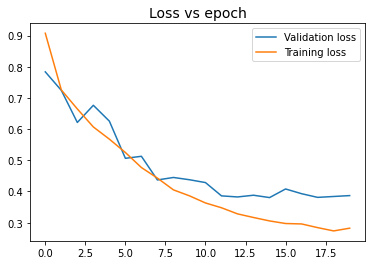

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.28232
accuracy,0.6624
val_loss,0.38685
val_accuracy,0.58777
_runtime,689
_timestamp,1619968878
_step,19
best_val_loss,0.38049
best_epoch,14


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▃▃▄▅▅▆▆▆▇▇▇▇▇██████
val_loss,█▇▅▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▃▄▅▅▇▇▇▇█████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: h3v56hid with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 3


cell_GRU_ncell_256_elayer_3_dlayer_1_emb_64_dp_0_bm_1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 64)     1728        EncoderInput[0][0]               
__________________________________________________________________________________________________
EncoderLayer1 (GRU)             [(None, None, 256),  247296      EncoderInputEmbedding[0][0]      
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
________________________________________

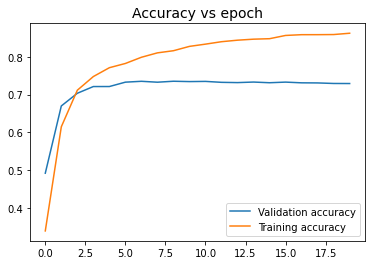

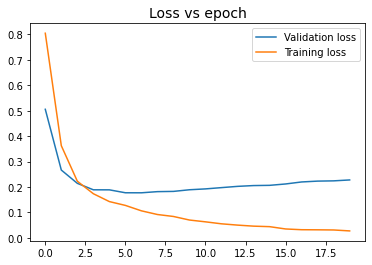

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.02708
accuracy,0.86181
val_loss,0.22754
val_accuracy,0.72908
_runtime,333
_timestamp,1619969221
_step,19
best_val_loss,0.17699
best_epoch,6


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▆▇▇▇▇▇███████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
val_accuracy,▁▆▇█████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 7l3sx6or with config:
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 256
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 1


cell_RNN_ncell_256_elayer_1_dlayer_2_emb_32_dp_0_bm_5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
________________________________________

In [ ]:
# Sweep configuration
sweep_config = {
  "name": "Assignment 3",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "cell_type": {
            "values": ["LSTM", "RNN", "GRU"]
        },
        "num_cells": {
            "values": [128, 256, 512]
        },
        "num_encoder_layers": {
            "values": [1, 2, 3]
        },
        "num_decoder_layers": {
            "values": [1, 2, 3]
        },
        "input_embedding_size": {
            "values": [16, 32, 64]
        },
        "dropout_fraction": {
            "values": [0, 0.1]
        },
        "beam_size": {
            "values": [1, 3, 5]
        }
    }
}

# Generates a sweep id
sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_3")
print(f"Sweep ID = {sweep_id}")
wandb.agent(sweep_id, train_with_wandb, count=100)

### Training function (No WANDB)

Use this to train the model with the best choice of hyperparameters obtained from Wandb.

In [ ]:
def train(num_cells, cell_type, num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, beam_size):
    """
    Function to train the model with the best set of hyperparameters (without WANDB)
    """
    # Define the model
    model = define_model(num_cells, cell_type, num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, beam_size)
    print(model.summary())

    # Display a plot of the model
    keras.utils.plot_model(model)

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
            [encoder_input_array, decoder_input_array],
            decoder_output_array,
            batch_size = 64,
            epochs = 20,
            verbose = 2,
            validation_data = ([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array)
            )

    # Save the trained model
    model.save("best_model.h5")

    # Plots of accuracy and loss
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.plot(history.history["accuracy"], label = "Training accuracy")
    plt.title("Accuracy vs epoch", size=14)
    plt.legend()
    plt.show()

    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.plot(history.history["loss"], label = "Training loss")
    plt.title("Loss vs epoch", size=14)
    plt.legend()
    plt.show()

    return model, history

### Training with the Best Hyperparameters

These are the best hyperparameters that we got from WANDB.

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 16)     432         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderLayer1 (LSTM)            [(None, None, 256),  279552      EncoderInputEmbedding[0][0]      
___________________________________________________________________________________________

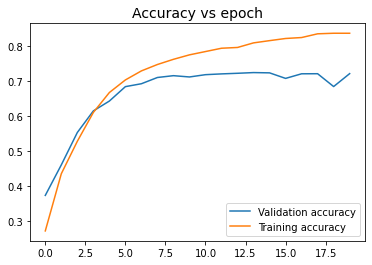

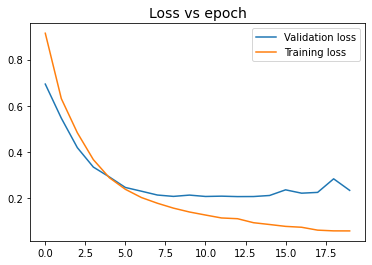

In [ ]:
# Best hyperparameters
num_cells = 256
cell_type = "LSTM"
num_encoder_layers = 2
num_decoder_layers = 1
input_embedding_size = 16
dropout_fraction = 0
beam_size = 1

model, history = train(num_cells, cell_type, num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, beam_size)

## Inference Section

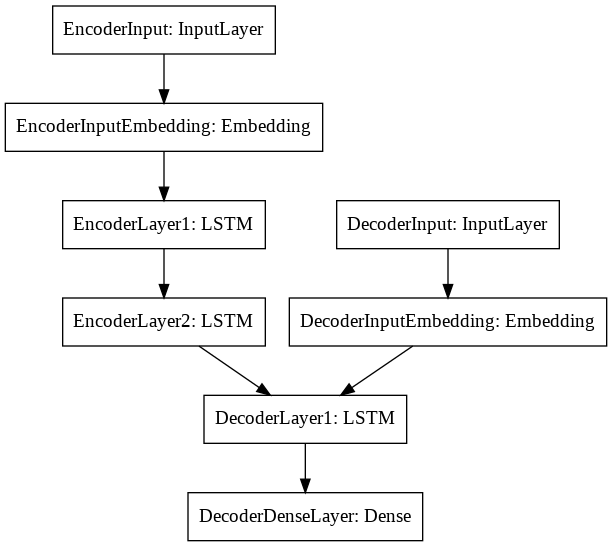

In [ ]:
keras.utils.plot_model(model)

### Inference for LSTM-based network

In [ ]:
# Input to the encoder, sequence of characters (word) in the source language
encoder_inputs = model.input[0]
# Output of the encoder
for layer in model.layers:
    if "EncoderLayer" in layer.name:
        _, state_h_enc, state_c_enc = layer.output
encoder_states = [state_h_enc, state_c_enc]


# Create an encoder model which outputs only cell states
encoder_model = keras.Model(encoder_inputs, encoder_states)


# Input to the decoder
decoder_inputs = model.input[1]
for layer in model.layers:
    if layer.name=="DecoderDenseLayer":
        decoder_dense = layer
    if "DecoderLayer1" in layer.name:
        decoder_lstm_first = layer
    if "DecoderLayer"+str(num_decoder_layers) in layer.name:
        decoder_lstm_last = layer
    if layer.name == "DecoderInputEmbedding":
        decoder_embedding_layer = layer


decoder_state_input_h = keras.Input(shape=(num_cells,))
decoder_state_input_c = keras.Input(shape=(num_cells,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h_dec, state_c_dec = decoder_lstm_first(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

for layer in model.layers:
    if "DecoderLayer" in layer.name and layer.name!="DecoderLayer1":
        decoder_outputs, state_h_dec, state_c_dec = layer(decoder_outputs, initial_state=decoder_states)
        decoder_states = [state_h_dec, state_c_dec]

# Softmax layer
decoder_outputs = decoder_dense(decoder_outputs)

# Create the decoder model
decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Dictionaries mapping from indices to characters
reverse_input_char_map = dict((i, char) for char, i in input_char_map.items())
reverse_target_char_map = dict((i, char) for char, i in target_char_map.items())


def transliterate_word_lstm(input_word):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_word)

    target_sequence = np.zeros((1, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[0, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    stop = False
    decoded_word = ""
    while not stop:
        output_tokens, h, c = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_index = np.argmax(output_tokens[0, -1, :])

        sampled_char = reverse_target_char_map[sampled_char_index]
        decoded_word += reverse_target_char_map[sampled_char_index]

        # Stop when the maximum sequence length is reached or when the stop character is found.
        if sampled_char == "\n" or len(decoded_word) >= max_decoder_seq_length:
            stop = True

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((1, 1, num_target_tokens+1))
        target_sequence[0, 0, sampled_char_index] = 1.0
        target_sequence = np.argmax(target_sequence, axis=2)

        # target_sequence = np.zeros((1, len(decoded_word), num_target_tokens))
        # for i, ch in enumerate(decoded_word):
        #     target_sequence[0, i, target_char_map[ch]] = 1.0

        # Update the hidden state and cell state 
        encoded_hidden_cell_states = [h, c]

    return decoded_word

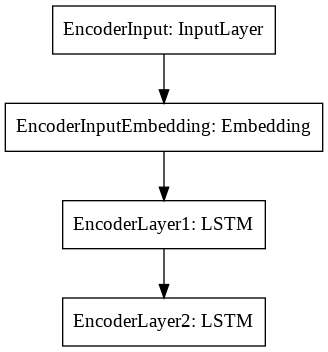

In [ ]:
keras.utils.plot_model(encoder_model)

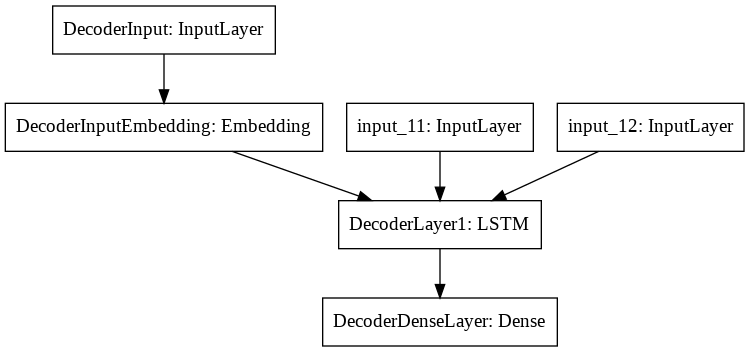

In [ ]:
keras.utils.plot_model(decoder_model)

In [ ]:
ground_truth = []
queries = []
outputs = []

random_indices = [113, 567, 3445, 68, 23432, 35, 2423, 3521, 5436, 3750, 123]

for i in random_indices:
    query = encoder_input_array[i:i+1]
    decoded_word = transliterate_word_lstm(query)
    queries.append(input_words[i])
    outputs.append(decoded_word.strip("\n"))
    ground_truth.append(target_words[i][1:-1]) # To remove the tab and newline characters

df_train = pd.DataFrame({"Input": queries, "Ground Truth" : ground_truth, "Model output":outputs})
df_train

,Input,Ground Truth,Model output
0,antardrishti,अंतर्दृष्टि,अंतर्दृष्टिका
1,adnan,अदनान,अदनान
2,aashavasan,आश्वासन,आश्वासन
3,undeworld,अंडरवर्ल्ड,उंदेवरूमी
4,presson,प्रेसों,प्रेसों
5,anguuron,अंगूरों,अंगूरों
6,iffa,आईफा,आईफा
7,ahyahan,आह्वाहन,आह्याधन
8,mnesti,एमनेस्टी,एनमैट्सी
9,ijajat,इजाज़त,इजाज़त


In [ ]:
ground_truth = []
queries = []
outputs = []

random_indices = [np.random.randint(0, M_train) for i in range(20)]

for i in random_indices:
    query = encoder_input_array[i:i+1]
    decoded_word = transliterate_word_lstm(query)
    queries.append(input_words[i])
    outputs.append(decoded_word.strip("\n"))
    ground_truth.append(target_words[i][1:-1]) # To remove the tab and newline characters

df_train = pd.DataFrame({"Input": queries, "Ground Truth" : ground_truth, "Model output":outputs})
df_train

,Input,Ground Truth,Model output
0,hirwani,हिरवानी,हिरवानी
1,kasheruka,कशेरुका,कशेरुका
2,gaagar,गागर,गागर
3,kushaa,कुशा,कुशा
4,sangita,संगीता,संगीता
5,varan,वरन,वरन
6,pattu,पट्टू,पत्लू
7,inder,इंदर,इंडर
8,upgrade,अपग्रेड,उपग्रदे
9,dhruv,ध्रुव,ध्रुव


### Transliteration performance on the training set

In [ ]:
ground_truth = []
queries = []
outputs = []
for i in range(20):
    query = encoder_input_array[i:i+1]
    decoded_word = transliterate_word_lstm(query)
    queries.append(input_words[i])
    outputs.append(decoded_word.strip("\n"))
    ground_truth.append(target_words[i][1:-1]) # To remove the tab and newline characters

df_train = pd.DataFrame({"Input": queries, "Ground Truth" : ground_truth, "Model output":outputs})
df_train

,Input,Ground Truth,Model output
0,an,अन,ऐं
1,ankganit,अंकगणित,अंकगणित
2,uncle,अंकल,अंकल
3,ankur,अंकुर,अंकुर
4,ankuran,अंकुरण,अंकुराण
5,ankurit,अंकुरित,अंकुरित
6,aankush,अंकुश,अंकुश
7,ankush,अंकुश,अंकुश
8,ang,अंग,अंग
9,anga,अंग,अंगा


In [ ]:
ground_truth = []
queries = []
outputs = []

random_indices = [np.random.randint(0, M_train) for i in range(20)]

for i in random_indices:
    query = encoder_input_array[i:i+1]
    decoded_word = transliterate_word_lstm(query)
    queries.append(input_words[i])
    outputs.append(decoded_word.strip("\n"))
    ground_truth.append(target_words[i][1:-1]) # To remove the tab and newline characters

df_train = pd.DataFrame({"Input": queries, "Ground Truth" : ground_truth, "Model output":outputs})
df_train

,Input,Ground Truth,Model output
0,shityuddh,शीतयुद्ध,शीतयुद्ध
1,crisis,क्राइसिस,क्राइसिस
2,dhanche,ढांचे,ढांचे
3,concept,कांसेप्ट,कांस्पैट
4,hawa,हवा,हवा
5,manorathon,मनोरथों,मनोरथों
6,dhokhebaji,धोखेबाजी,धोखेबाजी
7,triratn,त्रिरत्न,त्रिरत्न
8,return,रिटर्न,रिटर्न
9,qureshi,कुरैशी,क्रेशी


In [ ]:
model.evaluate([encoder_input_array, decoder_input_array], decoder_output_array)
model.evaluate([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array)
model.evaluate([test_encoder_input_array, test_decoder_input_array], test_decoder_output_array)

139/139 [==============================] - 1s 8ms/step - loss: 0.2345 - accuracy: 0.7149


[0.2344784438610077, 0.7149101495742798]

### Inference for RNN

In [ ]:
# Load saved model
model = keras.models.load_model("saved_model.h5")

# Input to the encoder, sequence of characters (word) in the source language
encoder_inputs = model.input[0]
# Output of the encoder
for layer in model.layers:
    if "EncoderLayer" in layer.name:
        _, encoder_states = layer.output

# Create an encoder model which outputs only cell states
encoder_model = keras.Model(encoder_inputs, encoder_states)


# Input to the decoder
decoder_inputs = model.input[1]
for layer in model.layers:
    if layer.name=="DecoderDenseLayer":
        decoder_dense = layer
    if "DecoderLayer1" in layer.name:
        decoder_rnn_first = layer
    if "DecoderLayer"+str(num_decoder_layers) in layer.name:
        decoder_rnn_last = layer

decoder_states_inputs = keras.Input(shape=(num_cells, ))

decoder_outputs, decoder_states = decoder_rnn_first(decoder_inputs, initial_state=decoder_states_inputs)

# Softmax layer
decoder_outputs = decoder_dense(decoder_outputs)

# Create the decoder model
decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs], [decoder_outputs] + [decoder_states])

# Dictionaries mapping from indices to characters
reverse_input_char_map = dict((i, char) for char, i in input_char_map.items())
reverse_target_char_map = dict((i, char) for char, i in target_char_map.items())


def transliterate_word_rnn(input_word):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_word)

    target_sequence = np.zeros((1, 1, num_target_tokens))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[0, 0, target_char_map["\t"]] = 1.0

    stop = False
    decoded_word = ""
    while not stop:
        output_tokens, state = decoder_model.predict([target_sequence] + [encoded_hidden_cell_states])

        # Sample the most probable character using softmax outputs
        sampled_char_index = np.argmax(output_tokens[0, -1, :])

        sampled_char = reverse_target_char_map[sampled_char_index]
        decoded_word += reverse_target_char_map[sampled_char_index]

        # Stop when the maximum sequence length is reached or when the stop character is found.
        if sampled_char == "\n" or len(decoded_word) >= max_decoder_seq_length:
            stop = True

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((1, 1, num_target_tokens))
        target_sequence[0, 0, sampled_char_index] = 1.0

        # Update the hidden state and cell state 
        encoded_hidden_cell_states = state

    return decoded_word

In [ ]:
ground_truth = []
queries = []
outputs = []

random_indices = [np.random.randint(0, M_train) for i in range(20)]

for i in random_indices:
    query = encoder_input_array[i:i+1]
    decoded_word = transliterate_word_rnn(query)
    queries.append(input_words[i])
    outputs.append(decoded_word.strip("\n"))
    ground_truth.append(target_words[i][1:-1]) # To remove the tab and newline characters

df_train = pd.DataFrame({"Input": queries, "Ground Truth" : ground_truth, "Model output":outputs})
df_train

,Input,Ground Truth,Model output
0,karyakushalata,कार्यकुशलता,स्रान
1,athaiya,अथैया,अनान
2,lautaati,लौटाती,लाका
3,kinare,किनारे,स्टे
4,cosmopolitan,कॉस्मोपॉलिटन,कार्य
5,shranagat,शरणागत,पार्य
6,sharad,शरद,प्राम
7,harminder,हरमंदिर,प्राम
8,baadhak,बाधक,बाय
9,goregaon,गोरेगांव,ब्रान


### Inference for GRU

In [ ]:
# Load saved model
model = keras.models.load_model("saved_model.h5")

# Input to the encoder, sequence of characters (word) in the source language
encoder_inputs = model.input[0]
# Output of the encoder
for layer in model.layers:
    if "EncoderLayer" in layer.name:
        _, encoder_states = layer.output

# Create an encoder model which outputs only cell states
encoder_model = keras.Model(encoder_inputs, encoder_states)


# Input to the decoder
decoder_inputs = model.input[1]
for layer in model.layers:
    if layer.name=="DecoderDenseLayer":
        decoder_dense = layer
    if "DecoderLayer1" in layer.name:
        decoder_gru_first = layer
    if "DecoderLayer"+str(num_decoder_layers) in layer.name:
        decoder_gru_last = layer

decoder_states_inputs = keras.Input(shape=(num_cells, ))

decoder_outputs, decoder_states = decoder_gru_first(decoder_inputs, initial_state=decoder_states_inputs)

# Softmax layer
decoder_outputs = decoder_dense(decoder_outputs)

# Create the decoder model
decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs], [decoder_outputs] + [decoder_states])

# Dictionaries mapping from indices to characters
reverse_input_char_map = dict((i, char) for char, i in input_char_map.items())
reverse_target_char_map = dict((i, char) for char, i in target_char_map.items())


def transliterate_word_gru(input_word):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_word)

    target_sequence = np.zeros((1, 1, num_target_tokens))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[0, 0, target_char_map["\t"]] = 1.0

    stop = False
    decoded_word = ""
    while not stop:
        output_tokens, state = decoder_model.predict([target_sequence] + [encoded_hidden_cell_states])

        # Sample the most probable character using softmax outputs
        sampled_char_index = np.argmax(output_tokens[0, -1, :])

        sampled_char = reverse_target_char_map[sampled_char_index]
        decoded_word += reverse_target_char_map[sampled_char_index]

        # Stop when the maximum sequence length is reached or when the stop character is found.
        if sampled_char == "\n" or len(decoded_word) >= max_decoder_seq_length:
            stop = True

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((1, 1, num_target_tokens))
        target_sequence[0, 0, sampled_char_index] = 1.0

        # Update the hidden state and cell state 
        encoded_hidden_cell_states = state

    return decoded_word

In [ ]:
ground_truth = []
queries = []
outputs = []

random_indices = [np.random.randint(0, M_train) for i in range(20)]

for i in random_indices:
    query = encoder_input_array[i:i+1]
    decoded_word = transliterate_word_gru(query)
    queries.append(input_words[i])
    outputs.append(decoded_word.strip("\n"))
    ground_truth.append(target_words[i][1:-1]) # To remove the tab and newline characters

df_train = pd.DataFrame({"Input": queries, "Ground Truth" : ground_truth, "Model output":outputs})
df_train

,Input,Ground Truth,Model output
0,shaukiya,शौकिया,शौकीय
1,foundation,फाउंडेशन,फांडिंग
2,aakrisht,आकृष्ट,आकृष्ट
3,jdane,जड़ने,जनानों
4,pahadi,पहाड़ी,पहली
5,namakyukt,नमकयुक्त,नमकीकता
6,achuta,अछूता,अछुत
7,staron,स्तरों,स्टरों
8,vishwavyapi,विश्वव्यापी,विश्ववास्त
9,amoniyaa,अमोनिया,अमेनिया
